In [1]:
from dysh.spectra.spectrum import Spectrum
import numpy as np
from scipy.stats import norm
import astropy.units as u
import matplotlib.pyplot as plt
from dysh.fits.sdfitsload import SDFITSLoad
from dysh.fits.gbtfitsload import GBTFITSLoad,sonoff
from dysh.spectra.scan import PSScan, GBTPSScan
import pandas
from copy import deepcopy
pandas.set_option('display.max_rows', 100)
from astropy.modeling.fitting import LevMarLSQFitter,LinearLSQFitter
from specutils import Spectrum1D, SpectrumList,SpectralRegion
from specutils.fitting import fit_continuum
import matplotlib.pyplot as plt


In [2]:
npts = 1000
x = np.arange(npts)
#print(x)
y = 3.1415927+np.random.rand(npts)+1000*norm(loc=npts/2,scale=50).pdf(x)
#y=1000*norm(loc=npts/2,scale=100).pdf(x)
s = Spectrum(flux=y*u.K,spectral_axis=x*u.um,velocity_convention='doppler_radio',radial_velocity=25*u.Unit('km/s'))
#print(y)
#s._spectral_axis.unit

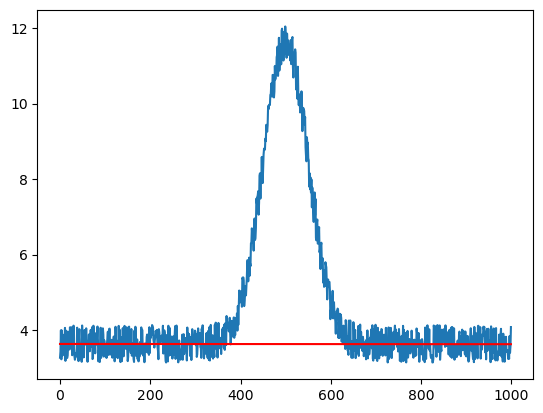

In [3]:
fig,ax=plt.subplots()
ax.plot(s.spectral_axis,s.flux)
s.baseline(1,exclude=[300,700],remove=False)
ax.plot(s.spectral_axis,s._baseline_model(s.spectral_axis),color='r')

In [4]:
print(s.stats())
s.bshow()

(<Quantity 4.63364978 K>, 2.1839198976009135, <Quantity 3.14273695 K>, <Quantity 12.04252675 K>)
baseline model Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 1
Parameters:
            c0                   c1          
            K                  K / um        
    ------------------ ----------------------
    3.6334654482755324 -6.172576823037911e-06


(<Quantity 1.00326754 K>, 2.1839209407667, <Quantity -0.48916333 K>, <Quantity 8.41214141 K>)
baseline model Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 1
Parameters:
            c0                   c1          
            K                  K / um        
    ------------------ ----------------------
    3.6334654482755324 -6.172576823037911e-06


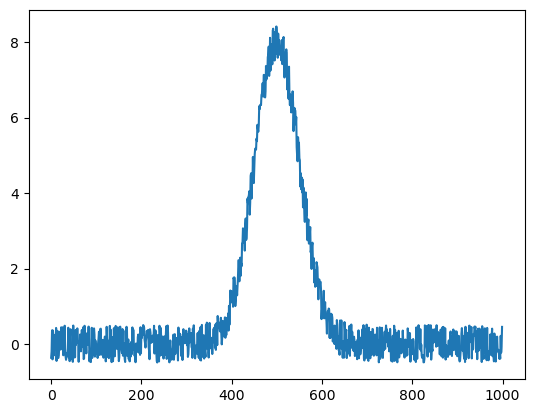

In [5]:
s = Spectrum(flux=y*u.K,spectral_axis=x*u.um,velocity_convention='doppler_radio',radial_velocity=25*u.Unit('km/s'))
s.baseline(1,exclude=[300,700],remove=True)
fig,ax=plt.subplots()
ax.plot(s.spectral_axis,s.flux)
print(s.stats())
s.bshow()

In [6]:
s._undo_baseline()
print(s.stats())
s.bshow()


(<Quantity 4.63364978 K>, 2.1839198976009135, <Quantity 3.14273695 K>, <Quantity 12.04252675 K>)
baseline model None


In [7]:
#f = '/data/gbt/examples/misc/ngc5291.fits'
f = '/data/gbt/examples/onoff-L/data/TGBT21A_501_11.raw.vegas.fits'
#f = '/data/gbt/examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.A.fits'
p = GBTFITSLoad(f)

==SDFITSLoad /data/gbt/examples/onoff-L/data/TGBT21A_501_11.raw.vegas.fits
doing pandas for HDU 1
==GBTLoad /data/gbt/examples/onoff-L/data/TGBT21A_501_11.raw.vegas.fits
0 OBJECT: ['NGC2415']
0 SCAN: [152, 153]
0 SAMPLER: ['A1_0', 'A2_0', 'A1_1', 'A2_1', 'A1_2', 'A2_2', 'A1_3', 'A2_3', 'A1_4', 'A2_4']
0 SIG: ['T']
0 CAL: ['F', 'T']
0 PROCSEQN: [1, 2]
0 PROCSIZE: [2]
0 OBSMODE: ['OnOff:PSWITCHON:TPWCAL', 'OnOff:PSWITCHOFF:TPWCAL']
0 SIDEBAND: ['L']


In [8]:
p.summary()[0]

/home/mpound/src/dysh/src/dysh/fits/gbtfitsload.py:85: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  _df = df[df.columns & show].copy()


,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,IFNUM,FEED,AZIMUTH,ELEVATIO,FDNUM
0,152,NGC2415,3784.0,OnOff,1,1.420406,0,1,285.951496,42.100624,0
1,152,NGC2415,3784.0,OnOff,1,1.420406,0,1,285.951496,42.100624,0
2,152,NGC2415,3784.0,OnOff,1,1.420406,0,1,285.951496,42.100624,0
3,152,NGC2415,3784.0,OnOff,1,1.420406,0,1,285.951496,42.100624,0
4,152,NGC2415,3784.0,OnOff,1,1.612231,1,1,285.951496,42.100624,0
...,...,...,...,...,...,...,...,...,...,...,...
6035,153,NGC2415,3784.0,OnOff,2,1.667359,3,1,287.149353,40.652970,0
6036,153,NGC2415,3784.0,OnOff,2,1.720530,4,1,287.149353,40.652970,0
6037,153,NGC2415,3784.0,OnOff,2,1.720530,4,1,287.149353,40.652970,0
6038,153,NGC2415,3784.0,OnOff,2,1.720530,4,1,287.149353,40.652970,0


In [24]:
print(sonoff(p.index(0)["SCAN"],p.index(0)["PROCSEQN"]))
myscans = set(sorted([153,155]))
scanlist=p.onoff_scan_list()
print(scanlist)
allscans = set(sorted(scanlist["ON"]+scanlist["OFF"]+[1,2,3,4,5]))
print(allscans)
z=allscans.intersection(myscans)
zz =allscans.difference(myscans)
zzz=myscans.difference(allscans)
print(z,zz,zzz)

{1: [152], 2: [153]}
{'ON': [152], 'OFF': [153]}
{1, 2, 3, 4, 5, 152, 153}
{153} {1, 2, 3, 4, 5, 152} {155}


In [11]:
psscan = p.getps(scans=[152])

ValueError: Scans {153} not found in bintable 0

In [10]:
df = p._ptable[0]
rows=list(df[df["SCAN"].isin(scans["ON"])].index)
df

,OBJECT,BANDWID,DATE-OBS,DURATION,EXPOSURE,TSYS,TDIM7,TUNIT7,CTYPE1,CRVAL1,...,CALTYPE,TWARM,TCOLD,CALPOSITION,IFNUM,PLNUM,FDNUM,PROC,_OBSTYPE,_SUBOBSMODE
0,NGC2415,23437500.0,2021-02-10T07:38:37.50,0.998244,0.975875,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,1.402545e+09,...,LOW,NaN,NaN,Unknown,0,1,0,OnOff,PSWITCHON,TPWCAL
1,NGC2415,23437500.0,2021-02-10T07:38:37.50,0.998244,0.975875,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,1.402545e+09,...,LOW,NaN,NaN,Unknown,0,1,0,OnOff,PSWITCHON,TPWCAL
2,NGC2415,23437500.0,2021-02-10T07:38:37.50,0.998244,0.975875,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,1.402545e+09,...,LOW,NaN,NaN,Unknown,0,0,0,OnOff,PSWITCHON,TPWCAL
3,NGC2415,23437500.0,2021-02-10T07:38:37.50,0.998244,0.975875,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,1.402545e+09,...,LOW,NaN,NaN,Unknown,0,0,0,OnOff,PSWITCHON,TPWCAL
4,NGC2415,23437500.0,2021-02-10T07:38:37.50,0.998244,0.975875,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,1.594439e+09,...,LOW,NaN,NaN,Unknown,1,1,0,OnOff,PSWITCHON,TPWCAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,NGC2415,23437500.0,2021-02-10T07:48:50.97,0.998244,0.040545,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,1.649555e+09,...,LOW,NaN,NaN,Unknown,3,0,0,OnOff,PSWITCHOFF,TPWCAL
6036,NGC2415,23437500.0,2021-02-10T07:48:50.97,0.998244,0.487937,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,1.702839e+09,...,LOW,NaN,NaN,Unknown,4,1,0,OnOff,PSWITCHOFF,TPWCAL
6037,NGC2415,23437500.0,2021-02-10T07:48:50.97,0.998244,0.040545,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,1.702839e+09,...,LOW,NaN,NaN,Unknown,4,1,0,OnOff,PSWITCHOFF,TPWCAL
6038,NGC2415,23437500.0,2021-02-10T07:48:50.97,0.998244,0.487937,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,1.702839e+09,...,LOW,NaN,NaN,Unknown,4,0,0,OnOff,PSWITCHOFF,TPWCAL


In [13]:
rows=p.onoff_rows()

In [ ]:
show = ["SCAN", "PROCSEQN", "PROCSIZE", "_OBSTYPE"]
df=df[df.columns & show]
df[df["_OBSTYPE"]=="PSWITCHOFF"]

In [ ]:
dict(p._ptable[0].iloc[0])

In [ ]:
df["RESTFREQ"]/=1E9
df["RESTFREQ"]

In [ ]:
show = ["SCAN", "OBJECT", "OBSMODE", "VELOCITY", "PROCSCAN", "PROCSEQN", "PROCTYPE", "PROCSIZE", "RESTFREQ", "IFNUM","FEED", "AZIMUTH", "ELEVATIO", "FDNUM"] 
scan = [60,61]
_df = df[df.columns & show].reindex(columns=show)

In [ ]:
_df["OBSMODE"].str.split(':',expand=True)

In [ ]:

_df[(_df["SCAN"]>=scan[0]) & ( _df["SCAN"] <= scan[1])]

In [ ]:
df["SCAN"]

In [ ]:
df['PROCTYPE']